In [ ]:
import os
import shutil
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproduzierbarkeit sicherstellen
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

2025-06-29 21:06:13.817492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 21:06:13.822587: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 21:06:13.832063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751223973.855756    1672 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751223973.862854    1672 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751223973.883627    1672 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

=== DATENÜBERSICHT ===
paper: 712 Bilder
rock: 726 Bilder
scissors: 750 Bilder

Gesamtanzahl: 2188 Bilder
Durchschnitt pro Klasse: 729.3


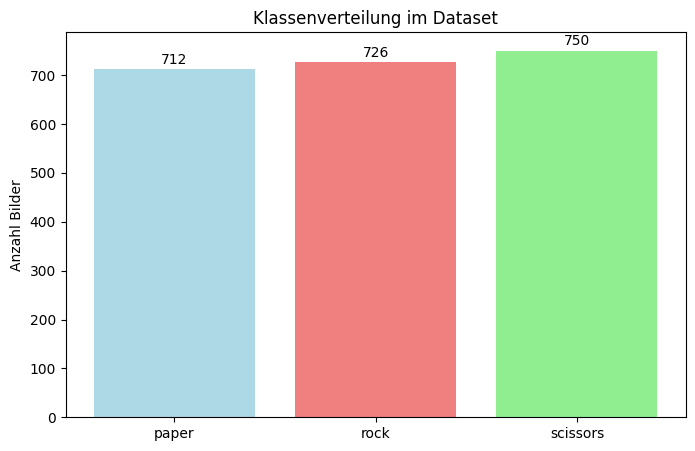

In [ ]:
DATA_DIR = "../data/raw"
IMG_SIZE = (200, 300)
BATCH_SIZE = 32

classes = ['paper', 'rock', 'scissors']
class_counts = {}

print("=== DATENÜBERSICHT ===")
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.png')]
    class_counts[cls] = len(images)
    print(f"{cls}: {len(images)} Bilder")

total_images = sum(class_counts.values())
print(f"\nGesamtanzahl: {total_images} Bilder")
print(f"Durchschnitt pro Klasse: {total_images/3:.1f}")

plt.figure(figsize=(8,5))
bars = plt.bar(classes, [class_counts[cls] for cls in classes], 
               color=['lightblue', 'lightcoral', 'lightgreen'])
plt.title("Klassenverteilung im Dataset")
plt.ylabel("Anzahl Bilder")
for bar, count in zip(bars, [class_counts[cls] for cls in classes]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom')
plt.show()

In [ ]:
DATA_DIR   = "../data/raw"
IMG_SIZE   = (200, 300)
BATCH_SIZE = 32
SEED       = 42
VAL_SPLIT  = 0.30

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take(val_batches // 2)
test_ds = val_test_ds.skip(val_batches // 2)

print(f"Train-Batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"  Val-Batches: {tf.data.experimental.cardinality(val_ds)}")
print(f" Test-Batches: {tf.data.experimental.cardinality(test_ds)}")

Found 2188 files belonging to 3 classes.
Using 1532 files for training.


E0000 00:00:1751223975.938901    1672 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751223975.939851    1672 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 2188 files belonging to 3 classes.
Using 656 files for validation.
Train-Batches: 48
  Val-Batches: 10
 Test-Batches: 11


2025-06-29 21:06:16.540424: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


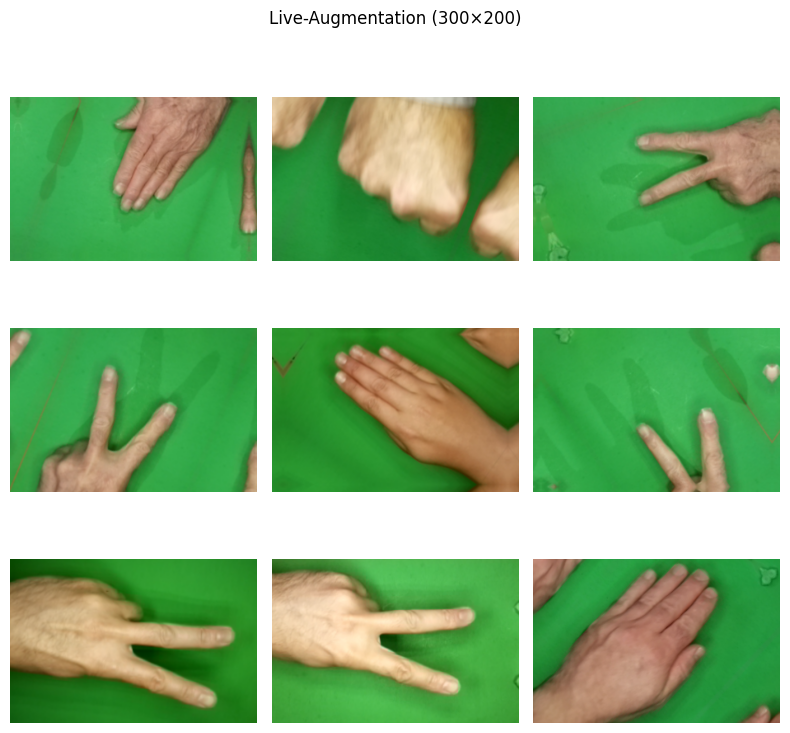

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

plt.figure(figsize=(8,8))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        aug_img = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Live-Augmentation (300×200)")
plt.tight_layout()
plt.show()

In [ ]:
def build_cnn(input_shape=(200,300,3), n_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    return model

model = build_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("../models/rps_best.h5", save_best_only=True)
]


In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.3647 - loss: 8.0571

48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3649 - loss: 7.9685 - val_accuracy: 0.4781 - val_loss: 1.0648
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4106 - loss: 1.0788

48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4110 - loss: 1.0780 - val_accuracy: 0.5688 - val_loss: 0.8289
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.6371 - loss: 0.8010

48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6373 - loss: 0.8008 - val_accuracy: 0.9094 - val_loss: 0.5201
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.7965 - loss: 0.5493

48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7964 - loss: 0.5489 - val_accuracy: 0.9219 - val_loss: 0.3425
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8644 - loss: 0.3710

48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8646 - loss: 0.3707 - val_accuracy: 0.9594 - val_loss: 0.1904
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8898 - loss: 0.3013 - val_accuracy: 0.9563 - val_loss: 0.1908
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.9066 - loss: 0.2652

48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9068 - loss: 0.2650 - val_accuracy: 0.9500 - val_loss: 0.1893
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 992ms/step - accuracy: 0.9036 - loss: 0.2780 - val_accuracy: 0.8375 - val_loss: 0.3559
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.8812 - loss: 0.2988

48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 981ms/step - accuracy: 0.8818 - loss: 0.2980 - val_accuracy: 0.9719 - val_loss: 0.1388
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9403 - loss: 0.1961

48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 992ms/step - accuracy: 0.9405 - loss: 0.1960 - val_accuracy: 0.9719 - val_loss: 0.0969
Epoch 11/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 977ms/step - accuracy: 0.9499 - loss: 0.1865 - val_accuracy: 0.9594 - val_loss: 0.1389
Epoch 12/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.9480 - loss: 0.1682

48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9480 - loss: 0.1683 - val_accuracy: 0.9781 - val_loss: 0.0905
Epoch 13/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9656 - loss: 0.1611 - val_accuracy: 0.9563 - val_loss: 0.1233
Epoch 14/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9482 - loss: 0.1550 - val_accuracy: 0.9656 - val_loss: 0.1192
Epoch 15/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9403 - loss: 0.1661

48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 988ms/step - accuracy: 0.9403 - loss: 0.1665 - val_accuracy: 0.9844 - val_loss: 0.0741


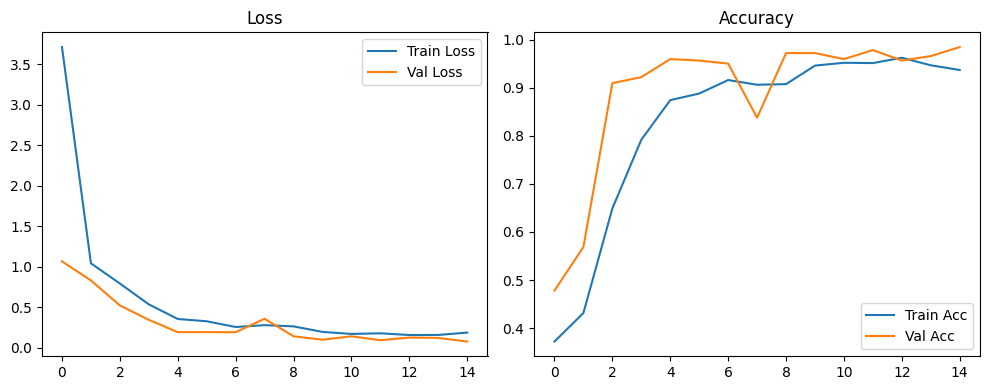

In [10]:
hist = history.history
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

       paper       0.98      0.97      0.97        96
        rock       1.00      1.00      1.00       109
    scissors       0.98      0.98      0.98       131

    accuracy                           0.99       336
   macro avg       0.99      0.98      0.98       336
weighted avg       0.99      0.99      0.99       336



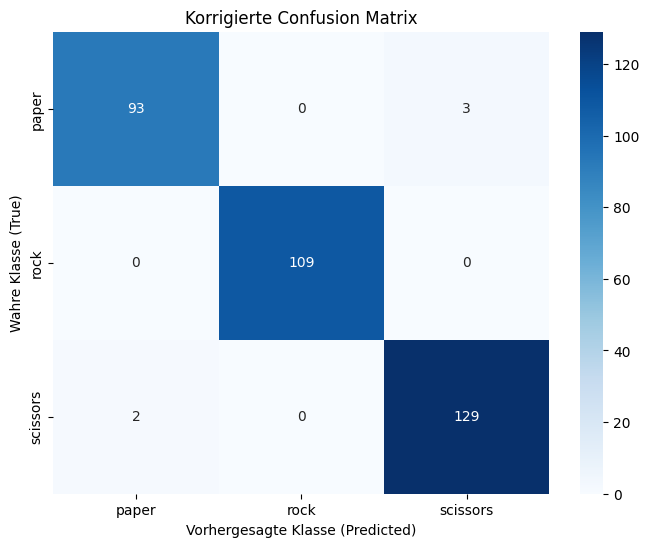

In [ ]:
y_pred_probs_list = []
y_true_list = []

for images, labels in test_ds:
    preds = model.predict_on_batch(images)
    y_pred_probs_list.append(preds)
    y_true_list.append(labels.numpy())

y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

y_pred = np.argmax(y_pred_probs, axis=1)

class_names = train_ds.class_names

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Korrigierte Confusion Matrix')
plt.ylabel('Wahre Klasse (True)')
plt.xlabel('Vorhergesagte Klasse (Predicted)')
plt.show()